# play with PLAsTiCC data (https://plasticc.org)

In [216]:
import sys
sys.path.append('../src')
from ztfanalysis import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize, curve_fit

In [303]:
meta = pd.read_csv('/Users/yash0613/Library/CloudStorage/Box-Box/ztf_data/plasticc_train_metadata.csv',
            sep=',').drop_duplicates()
meta = meta.query('true_target==62 and true_z<.1') # nearby Ibcs

In [304]:
print (meta.keys(), len(meta.index))

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object') 78


In [305]:
lcs = pd.read_csv('/Users/yash0613/Library/CloudStorage/Box-Box/ztf_data/plasticc_train_lightcurves.csv',
            sep=',').drop_duplicates()

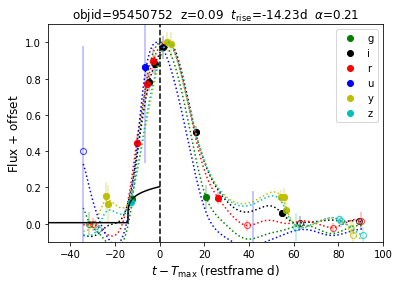

In [533]:
colors = dict()
colors['u'] = 'b'
colors['g'] = 'g'
colors['r'] = 'r'
colors['i'] = 'k'
colors['z'] = 'c'
colors['y'] = 'y'
t1 = -50
t2 = 100
nsn = 95450752
rel_flux_cutoff = .4
savefig = True

for n, i in enumerate(meta.index):
    objid = meta['object_id'][i]
    if objid != nsn: continue
    #if n != nsn: continue
    
    z = meta['true_z'][i]
    dm = meta['true_distmod'][i]
    mkebv = meta['mwebv'][i]
    jdpeak = meta['true_peakmjd'][i] + 2400000.5
    
    lc = lcs.query('object_id==@objid')
    lc['jdobs'] = lc['mjd'] + 2400000.5
    lc['Fmcmc'] = lc['flux']
    lc['Fmcmc_unc'] = lc['flux_err']
    fs = []
    for f in lc['passband']:
        if f == 0: fs.append('u')
        elif f == 1: fs.append('g')
        elif f == 2: fs.append('r')
        elif f == 3: fs.append('i')
        elif f == 4: fs.append('z')
        elif f == 5: fs.append('y')
    lc['filter'] = fs
    
    if len(lc.query('jdobs > @jdpeak+@t1 and jdobs < @jdpeak')) <=3:  continue
    
    # GP
    lc = lc.query('jdobs > @jdpeak+@t1 and jdobs < @jdpeak+@t2')
    ztfp = ztfsingle(ztfid=objid, iauid=objid, z=z, dm=dm, mkwebv=mkebv, sntype='SN Ibc')
    ztfp.lc = lc
    ztfp.run_gp(gp_type=2, 
            gp_routine='leastsq', 
            gp_mean='bazin', 
            kernel='matern32', 
            fix_scale=True,
            gp_fitr=[-100, 100], 
            gp_plotr=[-100, 100], 
            gp_bands=['u','g','r','i','z','y']
           )
    x, y, ye, w = ztfp.gpcls.x_pred, ztfp.gpcls.y_pred, ztfp.gpcls.y_prede, ztfp.gpcls.f_pred
    
    fig, ax = plt.subplots(1,1)
    xx, yy, yye = [], [], []
    for filt in np.unique(fs):
        _lc = lc.query('filter==@filt')
        if len(_lc)==0:continue
        fmax = ztfp.fpeak['GP'][filt][0]
        
        # GP
        ax.plot( (x[np.where(w==filt)]-jdpeak)/(1+z), y[np.where(w==filt)]/fmax,
            marker='None', color=colors[filt], ls=':', fillstyle='none' )
        # data
        ax.plot( (_lc['jdobs']-jdpeak)/(1+z), _lc['Fmcmc']/fmax, alpha=.6,
                marker='o', color=colors[filt], ls='', fillstyle='none' )
        ax.errorbar( (_lc['jdobs']-jdpeak)/(1+z), _lc['Fmcmc']/fmax, 
                yerr = _lc['Fmcmc_unc']/fmax, alpha=.3,
                marker='o', color=colors[filt], ls='', fillstyle='none' )
        
        __lc = _lc.query('Fmcmc/Fmcmc_unc > 1')
        if len(__lc) > 0:
            ax.plot( (__lc['jdobs']-jdpeak)/(1+z), __lc['Fmcmc']/fmax, 
                marker='o', color=colors[filt], ls='', alpha=1., label=filt )
        # early data
        __lc = _lc.query('jdobs < @jdpeak and Fmcmc < @fmax*@rel_flux_cutoff')
        xx = np.append( xx, (__lc['jdobs']-jdpeak)/(1+z) )
        yy = np.append( yy, __lc['Fmcmc']/fmax )
        yye = np.append( yye, __lc['Fmcmc_unc']/fmax )
    
    if len(xx) <= 3: continue
    _xx = np.arange(t1, 0, .01)
    BBparams, covar = curve_fit(powerlaw_full,xx,yy, method='trf',
            sigma=yye, absolute_sigma=True, p0=np.array([1, -20, 2, 0]),
            bounds = ([0,-60,.1,0], [2,-10,10,.5]), maxfev=20000)
    perr = np.sqrt(np.diag(covar))
    ax.plot( _xx, powerlaw_full(_xx, *BBparams), 'k-' )
    #print (BBparams)
    ax.set_title(r'objid=%s  z=%.2f  $t_{\mathrm{rise}}$=%.2fd  $\alpha$=%.2f'% 
                 (objid,z,BBparams[1],BBparams[2]),fontsize=12)
    ax.set_xlim([t1, t2])
    ax.set_ylim([-.1, 1.1])
    ax.set_xlabel('$t - T_{\mathrm{max}} \; (\mathrm{restframe \; d})$',fontsize=12)
    ax.set_ylabel('Flux + $\mathrm{offset}$',fontsize=12)
    ax.axvline(0, color='k', ls='--')
    ax.legend()
    if savefig: fig.savefig('plasticc/%i.png'%objid, dpi=400, bbox_inches='tight')